# Turnover number adjustment pipeline
Here we adjusted the turnover number estimates from [1], by fitting them to experimental measurements of protein abundance across multiple growth condition from [2]. Note that polypeptide abundances from [2] were previously mapped to enzyme mass abundances using the knowledge graph (see  `../enzyme_abundance_estimation`). By *simultaneously* fitting enzyme abundances across all growth conditions, our procedure generate a condition-indepenent adjusted parameter set which cab be used to predict average (in the geometric mean sense) enzyme abundances across condition. Here, we briefly outline the fitting procedure implemented in this script, but refer the user to our paper for a detailed description.

This procedure consist of three broad steps:

**Step 1: obtaining reference flux distributions**

In the first step, we use our initial (unadjusted) set of turnover numbers to predict a reference flux distribution for each condition. For this, we first use the enzyme-constrained FBA formalism to assign an enzyme cost per unit flux to each metabolic reaction. We compute the enzyme cost for reaction $i$ in condition $j$ as:
$$
    \begin{cases}
        \frac{M_i}{\sigma_j ~ k_{\text{cat},i} } \quad &\text{if reaction $i$ is enzymatic }\\
        0 \quad &\text{otherwise}
    \end{cases}
$$
where $M_i$ is the molecular weight of the enzyme associated with the reaction, $k_{\text{cat},i}$ is the turnover number for the enzyme-reaction pair, and $\sigma_j$ is a condition-specific coefficient (typically interpreted as an average enzyme saturation level) scaling the total enzyme abundance predicted for a flux distribution. 
Then, for each condition, we fix the growth rate to the experimentally measured value for that condition and solve for the flux distribution that achieves that growth rate with minimum total enzyme investment. Note that, formally, this is equivalent to maximise growth under a fixed bound on total enzyme budget.

**Step 2: Adjusting turnover numbers**

In this second step, we formulate and solve a Nonlinear program (NLP) that adjust the initial turnover numbers (up to a minimum/maximum fold adjustment) subject to the constraint that the reference distributions computed in the previous tep remain optimal for their respective condition.

**Step 3: Converting to apparent turnover number**

In the last step, we simply reparametrise the solution of the NLP so that the average saturation coefficents ($\sigma_j$) becomes embedded in the turnover estimates, and a resisual scaling fluctuating around one remains for each condition to account of different total amounts of measured enzyme abundances across conditions

In [1]:
import casadi as ca
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import sys
import NLP_wrapper 
import importlib
import gurobipy
from functools import reduce
import pickle

## 0. Preliminaries

### Load Data

In [2]:
#Enzyme constraint model
ec_model=cobra.io.read_sbml_model('../../Model/EC_iCH360/EC_iCH360_unadjusted_kcats.xml')
#block the defauult glucose uptake value
ec_model.reactions.EX_glc__D_e_bw.upper_bound=0

#Load estimtes of enzyme mass abundances
proteomic_data=pd.read_csv('../enzyme_abundance_estimation/schmidt_2016_mass_abundance_mapped_NNLS.csv',index_col='enzyme')
proteomic_data.head(1)

#Load metadata matching each column of the previosu table to the bigg carbon source and the experimentally measured growth rate for that condition
proteomic_data_metadata=pd.read_csv('../data/Schmidt_et_al_2016/parsed_data/Schmidt_et_all_2016_parsed_metadata.csv').query("strain=='BW25113' & type=='batch'")
proteomic_data_metadata.head(20)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-12


,condition_id,strain,type,condition,carbon_source,bigg_carbon_source,growth_rate
0,acetate,BW25113,batch,aerobic,acetate,ac_e,0.30
1,fumarate,BW25113,batch,aerobic,fumarate,fum_e,0.42
2,glycerol,BW25113,batch,aerobic,glycerol,glyc_e,0.47
3,pyruvate,BW25113,batch,aerobic,pyruvate,pyr_e,0.40
4,fructose,BW25113,batch,aerobic,fructose,fru_e,0.65
5,succinate,BW25113,batch,aerobic,succinate,succ_e,0.44
6,xylose,BW25113,batch,aerobic,xylose,xyl__D_e,0.55
11,glucose,BW25113,batch,aerobic,glucose,glc__D_e,0.58


In the proteomic data table, each row is an enzyme and each column is a condition

In [3]:
proteomic_data.head()

,glucose_g_gDW,acetate_g_gDW,fumarate_g_gDW,glycerol_g_gDW,pyruvate_g_gDW,fructose_g_gDW,succinate_g_gDW,xylose_g_gDW,glucose_chemostat_mu_0_5_g_gDW,glucose_chemostat_mu_0_12_g_gDW,glucose_chemostat_mu_0_20_g_gDW,glucose_chemostat_mu_0_35_g_gDW,glucose_MG1655_g_gDW,paxDB_g_gDW
enzyme,,,,,,,,,,,,,,
GCVMULTI-CPLX,0.003696,0.002812,0.003711,0.003233,0.005659,0.003702,0.004529,0.003644,0.004177,0.001887,0.002562,0.003129,0.003612,0.000731
ADENYLOSUCCINATE-SYN-DIMER,0.001927,0.001681,0.001499,0.001812,0.001724,0.001889,0.001579,0.002223,0.002359,0.001282,0.001346,0.001880,0.001923,0.000666
B2789-MONOMER,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
PGLYCDEHYDROG-CPLX,0.002974,0.001221,0.001276,0.001589,0.001598,0.002013,0.001133,0.003119,0.002538,0.000877,0.001083,0.001596,0.003174,0.000493
ACETOLACTSYNI-CPLX,0.000615,0.000690,0.000643,0.000900,0.000296,0.000690,0.000740,0.000789,0.000979,0.000746,0.000682,0.000779,0.000334,0.000109


###  Construct all required sets to make sure all vectors in the rest of the script are indexed in the correct order

In [4]:
#Reactions
reactions=[r for r in ec_model.reactions]
reactions.remove((ec_model.reactions.enzyme_pool_supply)) #remove the enzyme supply pseudoreaction
reaction_ids=[r.id for r in reactions]

#Metabolites
metabolites=[m for m in ec_model.metabolites]
metabolites.remove(ec_model.metabolites.enzyme_pool) #remove the enzyme pool pseudometabolite
metabolites_ids=[m.id for m in metabolites]

#Reaction-enzyme pairs
reaction_enzyme_pairs=[(r.id,r.annotation['smoment_enzyme']) for r in reactions if 'smoment_enzyme' in r.annotation.keys()]

#Original turnover numbers (in 1/s)
kcats0=np.array([float(ec_model.reactions.get_by_id(pair[0]).annotation['smoment_kcat_per_s']) for pair in reaction_enzyme_pairs]) 

#Model enzymes
model_enzymes=list(set([r.annotation['smoment_enzyme'] for r in reactions if 'smoment_enzyme' in r.annotation.keys()]))
model_enzymes.sort() #for reproducibility, as the conversion of list to set is non-determinsitic

#Map between condition names and bigg carbon source
conditions_carbon_source_map={row['condition_id']:row['bigg_carbon_source'] for i,row in proteomic_data_metadata.iterrows()}
all_carbon_sources=list(set(conditions_carbon_source_map.values()))
all_carbon_sources.sort() # for reproducibility (converting a list to a set yields a non-deterministic order)

#Measured enzyme abundances for each condition. as a dictionary of series
measured_proteome_series={cs:proteomic_data[condition_id+'_g_gDW'].loc[model_enzymes].dropna() for condition_id,cs in conditions_carbon_source_map.items()}

#remove zero measurements, as these are akin missing values
for cs in measured_proteome_series.keys():
    measured_proteome_series[cs]=measured_proteome_series[cs][measured_proteome_series[cs]>0]

# We don't have measurements for all model enzymes in each growth condition. 
# Hence, create a set index sets I_j such that, for each condition j, the subset of model enzymes for which we have measurements is given by:
# model_enzymes[I_j] 
# and this vector of the same length and order as measured_enzymes_j
measured_enzyme_ixs={cs:[model_enzymes.index(x) for x in measured_proteome_series[cs].index]
                     for cs in all_carbon_sources
                     }

### Construct the relevant matrices for Enzyme-constrained FBA

In [5]:
# The storichiometric matrix. This will be used to enforce steady state constraint in the reference flux distribution for condition j, v_j, i.e. Sv_j=0
S=cobra.util.array.create_stoichiometric_matrix(ec_model,'DataFrame').loc[metabolites_ids,reaction_ids].values

# The condition specific bound matrix and vectors. For each condition j, reference flux distribution v_j will have to satisfy:
# B_j@v_j==b_j
# Note that this also include fixing the growth rate to the experimental value
B_matrices={}
b_vectors={}
growth_rates_dict={cs:proteomic_data_metadata.query(f"bigg_carbon_source=='{cs}'").growth_rate.values[0] for cs in all_carbon_sources}

for cs in all_carbon_sources:
    B=np.empty((0,len(reaction_ids)),float)
    b=np.empty((0,1),float)
    with ec_model as model:
        ec_model.reactions.get_by_id("Biomass_fw").lower_bound=growth_rates_dict[cs]
        ec_model.reactions.get_by_id("Biomass_fw").upper_bound=growth_rates_dict[cs]
        model.reactions.get_by_id(f'EX_{cs}_bw').upper_bound=1000
        for i,r_id in enumerate(reaction_ids):
            r=model.reactions.get_by_id(r_id)
            if r.upper_bound<1000:
                new_B_row=np.zeros((1,len(reaction_ids)))
                new_B_row[0,i]=1
                B=np.append(B,new_B_row,axis=0)
                b=np.append(b,r.upper_bound*np.ones((1,1)),axis=0)
            if r.lower_bound>0:
                new_B_row=np.zeros((1,len(reaction_ids)))
                new_B_row[0,i]=-1
                B=np.append(B,new_B_row,axis=0)
                b=np.append(b,-r.lower_bound*np.ones((1,1)),axis=0)
    B_matrices[cs]=B
    b_vectors[cs]=b.reshape(-1,1)

### Misc functions which will be useful later

In [6]:
def RMSEL(x,y,treat_zeros_as=0.):
    """
    Root mean squared error of log10-transformed values, excluding zeros. Optional to treat zero value as a chosen value (e.g. a small epsilon)
    """
    x[x==0]=treat_zeros_as
    y[y==0]=treat_zeros_as
    SEL=0.
    count=0
    for i in range(x.shape[0]):
        if x[i]>0 and y[i]>0:
            SEL+=(np.log10(x[i])-np.log10(y[i]))**2
            count+=1
    return np.sqrt(SEL/count)

def compute_enzyme_predictions(log10_kcats,v,log10_sigma,return_type='casadi'):
    """
    Compute prediction for each reaction-enzyme pair given log10-turnover numbers <log10_kcats>, a flux distribution <v>, and a log10-saturation coefficient <log10_sigma>.
    Different return types are possible (one of 'numpy', 'gurobipy', or 'casadi') depending on weather the passed arguments are numberic values, gurobipy variables, or casadi variables
    """
    enzyme_predictions=[0.]*len(model_enzymes) #placeholder
    
    for reaction_id,enzyme_id in reaction_enzyme_pairs:
        r=ec_model.reactions.get_by_id(reaction_id)
        MW=float(r.annotation['smoment_mw'])

        #Find the index of the current reaction, enzyme, and kcat in the relevant vectors
        reaction_ix=reaction_ids.index(reaction_id)
        enzyme_ix=model_enzymes.index(enzyme_id)
        kcat_ix=reaction_enzyme_pairs.index((reaction_id,enzyme_id))
        #Add the contribution of this reaction to the enzyme cost for enzyme_id
        enzyme_predictions[enzyme_ix]+=(MW/(10**(log10_kcats[kcat_ix]+log10_sigma)*3600))*v[reaction_ix]
    if return_type=='casadi':
        return ca.vertcat(*enzyme_predictions)
    elif return_type=='gurobipy':
        return enzyme_predictions
    elif return_type=='numpy':
        return np.array(enzyme_predictions)
    


def flux_costs_from_kcats(log10_kcats,log10_sigma,scaling=1):
    """
    Compute flux costs for each reaction-enzyme pair given log10-turnover numbers <log10_kcats> and a log10-saturation coefficient <log10_sigma>.
    Since enzyme costs are typically small numbers, it may sometimes be desired to scale the cost by a factor <scaling>, to improve numerical conditioning of the Enzyme-constrained FBA problem 
    Note that scaling all costs by a constant factor will NOT affect the optimal flux distribution  (i.e. te minimizing total enzyme cost) for a given growth rate.
    """
    flux_costs=[0.]*len(reaction_ids)
    for r_id,enzyme_id in reaction_enzyme_pairs:
        r=ec_model.reactions.get_by_id(r_id)
        MW=float(r.annotation['smoment_mw'])
        reaction_ix=reaction_ids.index(r_id)
        kcat_ix=reaction_enzyme_pairs.index((r_id,enzyme_id))
         
        flux_costs[reaction_ix]=scaling*MW/(10**(log10_kcats[kcat_ix]+log10_sigma)*3600)
        
    return flux_costs

def geometric_mean(x):
    """
    Geometric mean of an array of values, potentially containing zeros. Zeros are simply ommitted from the calculation
    """
    x_nonzero=x[x>0]
    return np.exp(np.log(x_nonzero).mean())

## Construct the two optimisation problems. 


### Step 1: Construct A Linear program to obtain reference flux distributions for each condition given a set of turnover numbers
The reference flux distribution for condition $j$, $v_j^*$ is obtained as:
$$
    \begin{aligned}
    \v{v}_j^*=\argmin_{\v{v}}  &\quad {a}_j^\top {v}  \\
                     \rm{s.t.} &\quad {S}{v}={0} &\qquad \qquad \rm{(a)} \\
                               &\quad \hat{{B}}_j{v}\leq \hat{{b}}_j &\qquad \qquad \rm{(b)}\\
                               & \quad {v}\geq \v{0}
\end{aligned}
$$

where 
- $a_j$ is a vector of enzyme costs for condiion $j$, 
- S is the stoichiometric matrix, 
- $B_j$ and $b_j$ are a matrix and a vector encoding conditon-specific bounds on fluxes, including the experimentally measured growth rate (see previous section)

In [7]:
importlib.reload(NLP_wrapper)
def solve_lp_problem(carbon_sources,
                    log10_kcats,
                    log10_sigmas=None,
                    verbose=False,
                    scale_enzyme_predictions=False,
                    cost_scaling=1000):
    """
    Formulates and solves the above LP in gurobipy for multiple growth conditions.
    If <scale_enzyme_prediction> is true, enzyme predictions are scaled so that their sum matches the sum of the experimentally measured ones (i.e. the scaling factor sigma is estimated from data).
    Otherwise, predictions are reported for the provided scalings values (if these are not specified, a default value of 1 is used for all conditions).

    <cost_scaling> is a fixed caling factor for all flux cost which can improve numerical conditioning of the LP (which would otherwise be poorly scaled) but doesn't formally change the optimal solution of the problem.
    """
    if log10_sigmas is None:
        log10_sigmas={cs:0. for cs in carbon_sources}
    gp_lp=gurobipy.Model()
    v={cs:gp_lp.addMVar(len(reaction_ids),lb=[0.]*len(reaction_ids),ub=[1000.]*len(reaction_ids),name=f'v_{cs}') for cs in carbon_sources}
    all_flux_costs={}
    obj=0.
    for cs in carbon_sources:
        gp_lp.addConstr(S@v[cs]==0,name=f'mass_balance_{cs}')
        gp_lp.addConstr(B_matrices[cs]@v[cs]<=b_vectors[cs].flatten(),name=f'B_{cs}')
        flux_costs=flux_costs_from_kcats(log10_kcats=log10_kcats,
                                         log10_sigma=log10_sigmas[cs],
                                         scaling=cost_scaling)
        flux_costs=np.array(flux_costs)
        all_flux_costs[cs]=flux_costs
        obj+=gurobipy.quicksum([cost*v[cs][i] for i,cost in enumerate(flux_costs)])
        

        #Add a lil regularisation to make the solution unique
    gp_lp.setObjective(obj,sense=gurobipy.GRB.MINIMIZE)
    gp_lp.setParam('OutputFlag',1)
    gp_lp.optimize()
    out_fluxes={cs: v[cs].X for cs in carbon_sources}
    unscaled_enzyme_predictions={cs:compute_enzyme_predictions(log10_kcats=log10_kcats,
                                                                v=out_fluxes[cs],
                                                                log10_sigma=log10_sigmas[cs],
                                                                return_type='numpy')
                                for cs in carbon_sources}
    if scale_enzyme_predictions:
        scaled_enzyme_predictions={}
        for cs in carbon_sources:
            cur_scaling=unscaled_enzyme_predictions[cs][measured_enzyme_ixs[cs]].sum()/measured_proteome_series[cs].sum()
            scaled_enzyme_predictions[cs]=unscaled_enzyme_predictions[cs]/cur_scaling
    else:
        scaled_enzyme_predictions=None


    if verbose:
        #Print solution status
        status = gp_lp.status
        print(f'Solved LP with given log10_kcats and log10_sigmas for carbon sources {carbon_sources}. Status: {status}')
    return {'fluxes':out_fluxes,
            'unscaled_enzyme_predictions':unscaled_enzyme_predictions,
            'scaled_enzyme_predictions':scaled_enzyme_predictions,
            'flux_costs':all_flux_costs
                                  }

### Step 2: Construct the kcat adjustment problem
This is a nonlinear programming (NLP) formulation that, given a set of reference flux distributions, adjust the initial turnover numbers to minimize discrepancy with the measured enzyme abundances, subject to the constraint that the provided reference distributions remain optimal for their respective condition. This constraint is implemented by including in the optimisation space dual variables for each conditions and enforcing the sufficient optimality condition of the EC-FBA LP. The NLP is formulated as:

$$
    \begin{aligned}
     ({p}^*, {s}^*)= \argmin_{{p},~{s}}  &\quad  \frac{1}{N_{\rm e}}\sum_{i,j}~\big[ ~l( e_{ij})-l(\bar{e}_{ij})~\big]^2 + \frac{\rho}{N_{\rm p}} \sum_i \big(~p_i -\bar{p}_i~\big)^2 \\
                     \rm{s.t.} &\quad {l}\leq {p}-\bar{{p}} \leq {u} \\
                               &\quad{S}^\top{\lambda}_j~+{B}_j^\top {u}_j + {a}_j \geq {0} &\quad j=1,\dotsc,J\\
                               &\quad {u}_j \geq {0}                                     &\quad j=1,\dotsc,J\\
                               &\quad {a}_j^\top{v}_j^*=-{b}_j^\top {u}_j                    &\quad j=1,\dotsc,J
\end{aligned}

$$
where:
- $p$ are the lo10 turnover numbers, and $\bar{p}$ are their initial (unadjusted) values
- $s$ is a vector of log10 scalings ($\sigma$ values), one per condition
- $e_{i,j}$ and $\bar{e}_{i,j}$ are predicted and measured enzyme abundances, respectively.
- the function $l(\cdot)$ is defined as : $    \begin{cases}
        \log_{10}(x) \quad  &x>0 \\
        0       \quad &x=0
    \end{cases}$
- $\rho$ is a ridge regularisation hyperparameter, used to penalise large deviation from the oriignal parameter set
- $N_e$ and $N_p$ are the numbers of enxyme-condition pairs and turnover numbers, respectively
- $l$ and $u$ are bounds for the adjustment of turnover parameters
- $S$, $B_j$, $b_j$, $a_j$ are defined as before
- $\lambda_j$ is a vector of dual variables for the equality constraints of the LP (for condition $j$)
- $\mu_j$ is a vector of dual variables for the inequality constraints of the LP (for condition $j$), which has to be non-negative

Please see our paper for more details on the formulation of this NLP!

In [8]:

def construct_kcat_adjustment_nlp(carbon_sources):
    """
    Formulate the above parametric NLP in CasADi. To simplify legibility, we wrote a simple around the CasADi API (you can find it in the same folder of this script)
    """
    problem=NLP_wrapper.NLP()
    v={cs:ca.SX.sym(f"v_{cs}",len(reaction_ids),1) for cs in carbon_sources}
    lam={cs:ca.SX.sym(f"lam_{cs}",S.shape[0],1) for cs in carbon_sources}
    mu={cs:ca.SX.sym(f"mu_{cs}", B_matrices[cs].shape[0],1) for cs in carbon_sources}
    log10_sigmas={cs:ca.SX.sym(f"log10_sigma_{cs}",1,1) for cs in carbon_sources}
    log10_kcats=ca.SX.sym(f"log10_kcats",len(kcats0)) 

    problem.add_variable(var=log10_kcats,name="log10_kcats",lb=np.log10(kcats0)-4,ub=np.log10(kcats0)+4,x0=np.log10(kcats0))
    problem.add_constraint(log10_kcats,'>',np.log10(kcats0).reshape(-1,1)-2.)
    problem.add_constraint(log10_kcats,'<',np.log10(kcats0).reshape(-1,1)+2.)
    rho_reg=ca.SX.sym("rho_reg",1,1) #rideg regularisation coefficient rho
    problem.add_parameter(rho_reg,name='ridge_coefficient')
    MSE=0.
    data_points_count=0.
    for cs in carbon_sources:
        #Saturation
        problem.add_variable(log10_sigmas[cs],name=f"log10_sigma_{cs}",lb=np.log10(0.1),ub=np.log10(1.))
        #Fluxes
        problem.add_parameter(v[cs],name=f"v_{cs}")
        #Lagrange multipliers for eq. constraints
        problem.add_variable(lam[cs],f"lam_{cs}",lb=None,ub=None)
        #Lagrange multiplier for inequality constraints
        problem.add_variable(mu[cs],f"mu_{cs}",lb=0.)

        #============

        flux_costs=flux_costs_from_kcats(log10_kcats=log10_kcats,
                                        log10_sigma=log10_sigmas[cs],
                                        scaling=1000)
        flux_costs=ca.vertcat(*flux_costs)
        optimised_enzyme_predictions=compute_enzyme_predictions(log10_kcats=log10_kcats,
                                                                v=v[cs],
                                                                log10_sigma=log10_sigmas[cs],
                                                                return_type='casadi')
        #===========
        #Dual feasibility
        problem.add_constraint(S.T@lam[cs]+\
                            B_matrices[cs].T@mu[cs]+\
                                (flux_costs),
                                '>',
                                0.)
        #Strong duality
        problem.add_constraint(-(flux_costs).T@v[cs] - mu[cs].T@b_vectors[cs],'=',0.)

        for i,j in enumerate(measured_enzyme_ixs[cs]):
            MSE+=ca.if_else(
                            optimised_enzyme_predictions[j]>0,
                            (ca.log(optimised_enzyme_predictions[j])-
                            ca.log(measured_proteome_series[cs].values[i])
                            )**2,
                            0.
                            )
            data_points_count+=1
            
    MSE=MSE/data_points_count
    regularisation=(1/len(kcats0))*ca.sumsqr(log10_kcats-np.log10(kcats0))

    problem.set_objective(MSE+rho_reg*regularisation,sense='min')

    problem.construct_nlp(opts={'ipopt':{'print_level':5}})
    return problem

def constrained_kcat_adjustment(nlp,flux_vectors,ridge_coefficient,warm_start=None):
    """
    Solve the parametric NLP for a given choice of parameter, namely:
    - reference flux distribution (one per condition), <flux_vectors>
    - a value for the ridge regularisation coefficient rho (<ridge_coefficient>)
    - if a warm_start dict is given, use that to intialise the solver (useful if the problem is solved many time while changing a parameter )
    """
    parameters={}
    for cs,v in flux_vectors.items():
        parameters[f"v_{cs}"]=v.flatten().tolist()
    parameters['ridge_coefficient']=ridge_coefficient
    sol,warm_start,status=nlp.solve(parameters=parameters,warm_start=warm_start,verbose=True)
    return {'log10_kcats':sol['log10_kcats'].flatten(),
            'log10_sigmas':{cs:sol[f'log10_sigma_{cs}'][0,0] for cs in flux_vectors.keys()},
            'enzyme_predictions':{cs:compute_enzyme_predictions(log10_kcats=sol['log10_kcats'],
                                                                v=flux_vectors[cs],
                                                                log10_sigma=sol[f"log10_sigma_{cs}"],
                                                                return_type='numpy')
                                    for cs in flux_vectors.keys()}, 
            'warm_start':warm_start,
            'status':status,
    }


Now, merge the two step into a single pipeline

In [9]:

def kcat_adjustment_pipeline(carbon_sources,log10_kcats0,ridge_coefficient=1e-3,warm_start=None):
    nlp=construct_kcat_adjustment_nlp(carbon_sources)

    initial_lp_sol=solve_lp_problem(carbon_sources=carbon_sources,
                                log10_kcats=log10_kcats0,
                                log10_sigmas=None,
                                verbose=True,
                                scale_enzyme_predictions=True)

    nlp_sol=constrained_kcat_adjustment(nlp=nlp,
                                        flux_vectors=initial_lp_sol['fluxes'],
                                        ridge_coefficient=ridge_coefficient,
                                        warm_start=warm_start)

    final_lp_sol= solve_lp_problem(carbon_sources=carbon_sources,
                                    log10_kcats=nlp_sol['log10_kcats'],     
                                    log10_sigmas=nlp_sol['log10_sigmas'],
                                    verbose=True,
                                    scale_enzyme_predictions=False)


    #1 Kcats
    kcat_df=pd.DataFrame()
    kcat_df['enzyme']=[pair[1] for pair in reaction_enzyme_pairs]
    kcat_df['reaction_id']=[pair[0] for pair in reaction_enzyme_pairs]
    kcat_df['original_kcats']=10**(log10_kcats0)
    kcat_df['adjusted_kcats']=10**(nlp_sol['log10_kcats'])
    kcat_df['fold_change']=kcat_df['adjusted_kcats']/kcat_df['original_kcats']

    enzyme_allocation_df=pd.DataFrame()
    for cs in carbon_sources:   
        cur_df=pd.DataFrame()
        cur_df['enzyme']=[model_enzymes[i] for i in measured_enzyme_ixs[cs]]
        cur_df['carbon_source']=cs
        cur_df['measured']=measured_proteome_series[cs].values
        cur_df['unadjusted_predicted']=initial_lp_sol['scaled_enzyme_predictions'][cs][measured_enzyme_ixs[cs]]
        cur_df['adjusted_predicted']=final_lp_sol['unscaled_enzyme_predictions'][cs][measured_enzyme_ixs[cs]]
        enzyme_allocation_df=pd.concat([enzyme_allocation_df,cur_df])
        enzyme_allocation_df['fold_change']=enzyme_allocation_df['adjusted_predicted']/enzyme_allocation_df['measured']


    return {'kcats':kcat_df,
            'enzyme_allocation':enzyme_allocation_df,
            'scalings':pd.Series({cs:10**(nlp_sol['log10_sigmas'][cs]) 
                                  for cs in carbon_sources}
                                ),
            'initial_lp_sol':initial_lp_sol,
            'nlp_sol':nlp_sol,
            'final_lp_sol':final_lp_sol,
            'warm_start':nlp_sol['warm_start']}

## Testing that the pipeline works

### Run for a single condition (glucose)

In [10]:
carbon_sources=['glc__D_e']
log10_kcats0=np.log10(kcats0)
results=kcat_adjustment_pipeline(carbon_sources=carbon_sources,
                                log10_kcats0=log10_kcats0,
                                ridge_coefficient=1e1)



Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 325 rows, 504 columns and 2001 nonzeros
Model fingerprint: 0x83dfad44
Coefficient statistics:
  Matrix range     [6e-04, 8e+01]
  Objective range  [4e-03, 4e+03]
  Bounds range     [1e+03, 1e+03]
  RHS range        [6e-01, 7e+00]
Presolve removed 252 rows and 367 columns
Presolve time: 0.02s
Presolved: 73 rows, 137 columns, 597 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1964436e+03   6.726157e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 8
      79    1.0779313e+02   0.000000e+00   0.000000e+00      0s

Solved in 79 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.077931326e+02
Solved LP with given log10_kcats and log10_sigmas for carbon sour

### Verify that kcat adjustment did not change optimal fluxes

In [11]:
initial_lp_sol=results['initial_lp_sol']['fluxes']['glc__D_e']
final_lp_sol=results['final_lp_sol']['fluxes']['glc__D_e']
for i,r_id in enumerate(reaction_ids):
    initial=results['initial_lp_sol']['fluxes']['glc__D_e'][i]
    final=results['final_lp_sol']['fluxes']['glc__D_e'][i]
    if np.abs(initial-final)>1e-6:
        print(f"kcats adjustement changed flux for reaction {r_id} by {final/initial} - fold")

### Plot initial vs adjusted enzyme predictions

Text(0.5, 1.0, 'Adjusted enzyme predictions')

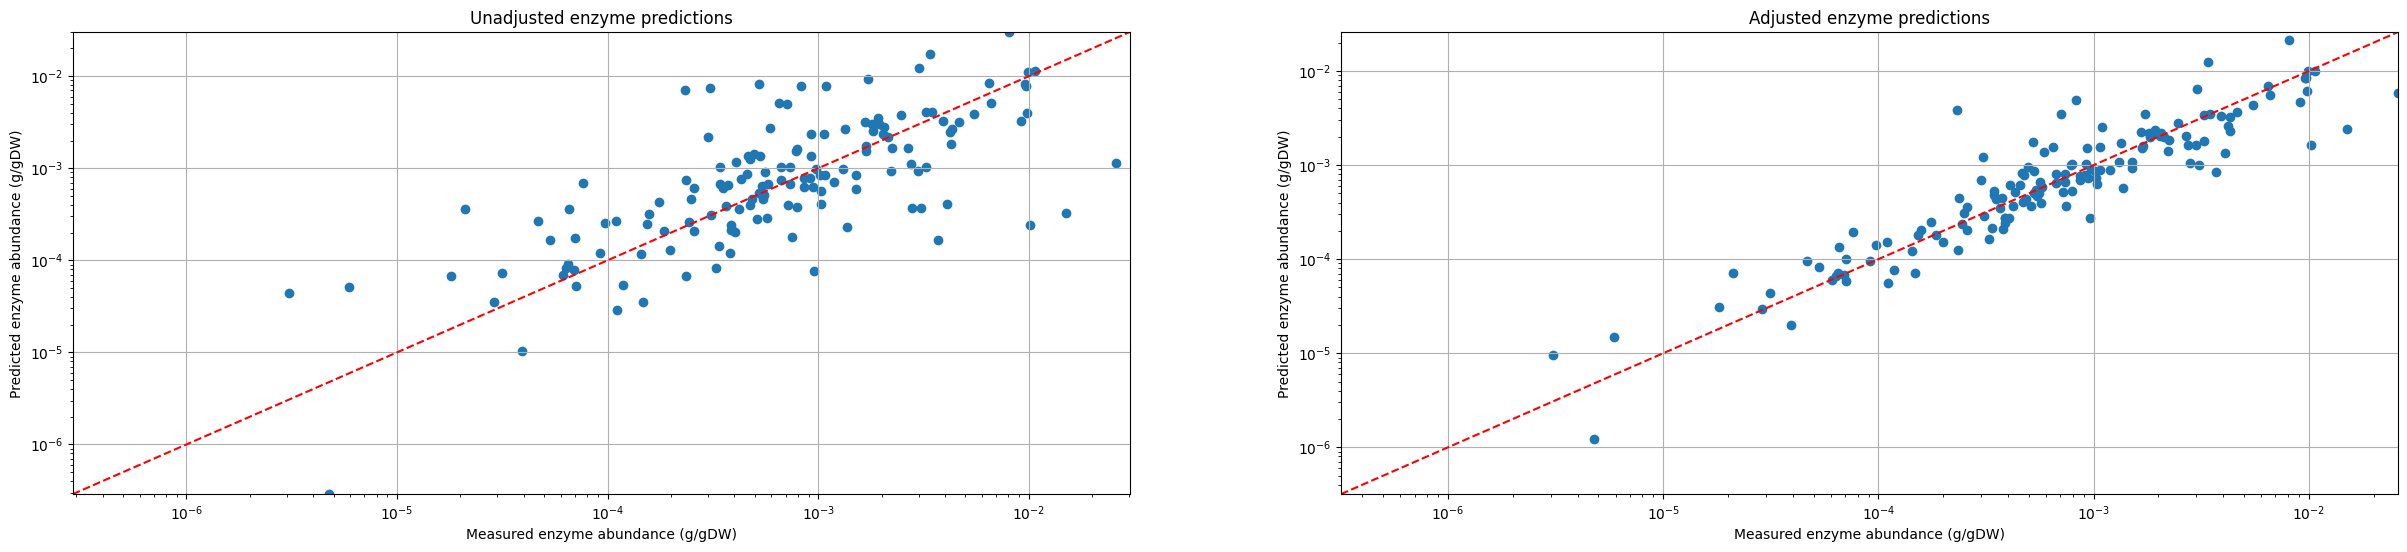

In [12]:
fig,ax=plt.subplots(1,2,figsize=(30,6))

#merge measured and predicted in one looong b_vectors

enzyme_allocations=results['enzyme_allocation']
kcats=results['kcats']


measured_all_cs=enzyme_allocations['measured'].values
predicted_all_cs=enzyme_allocations['adjusted_predicted'].values
predicted_all_cs_unadjusted=enzyme_allocations['unadjusted_predicted'].values

ax[0].scatter(measured_all_cs,predicted_all_cs_unadjusted)
ax[0].set_xlabel('Measured enzyme abundance (g/gDW)')
ax[0].set_ylabel('Predicted enzyme abundance (g/gDW)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(measured_all_cs[measured_all_cs>0]),np.min(predicted_all_cs_unadjusted[predicted_all_cs_unadjusted>0])),max(np.max(measured_all_cs[measured_all_cs>0]),np.max(predicted_all_cs_unadjusted[predicted_all_cs_unadjusted>0]))]
ax[0].set_xlim(shared_limits)
ax[0].set_ylim(shared_limits)
#Draw diagonal line
ax[0].plot(shared_limits,shared_limits,'r--')
ax[0].grid()
ax[0].set_title('Unadjusted enzyme predictions')
#=========)


ax[1].scatter(measured_all_cs,predicted_all_cs)
ax[1].set_xlabel('Measured enzyme abundance (g/gDW)')
ax[1].set_ylabel('Predicted enzyme abundance (g/gDW)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(measured_all_cs[measured_all_cs>0]),np.min(predicted_all_cs[predicted_all_cs>0])),max(np.max(measured_all_cs[measured_all_cs>0]),np.max(predicted_all_cs[predicted_all_cs>0]))]
ax[1].set_xlim(shared_limits)
ax[1].set_ylim(shared_limits)
#Draw diagonal line

ax[1].plot(shared_limits,shared_limits,'r--')
ax[1].grid()
ax[1].set_title('Adjusted enzyme predictions')

### Now try to run the pipeline by simultaneously fitting many conditions simultaneously

In [13]:
carbon_sources=all_carbon_sources
log10_kcats0=np.log10(kcats0)
results=kcat_adjustment_pipeline(carbon_sources=carbon_sources,
                                log10_kcats0=log10_kcats0,
                                ridge_coefficient=1.)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2600 rows, 4032 columns and 16008 nonzeros
Model fingerprint: 0x8cdd85de
Coefficient statistics:
  Matrix range     [6e-04, 8e+01]
  Objective range  [4e-03, 4e+03]
  Bounds range     [1e+03, 1e+03]
  RHS range        [3e-01, 7e+00]
Presolve removed 2011 rows and 2936 columns
Presolve time: 0.02s
Presolved: 589 rows, 1096 columns, 4866 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5626703e+04   5.141554e+03   0.000000e+00      0s
Extra simplex iterations after uncrush: 92
     752    8.7546982e+02   0.000000e+00   0.000000e+00      0s

Solved in 752 iterations and 0.02 seconds (0.02 work units)
Optimal objective  8.754698192e+02
Solved LP with given log10_kcats and log10_sigmas for c

### Again, verify that the adjustment procedure did not affect the optimal flux distributions

In [14]:
initial_lp_sol=results['initial_lp_sol']['fluxes']['glc__D_e']
final_lp_sol=results['final_lp_sol']['fluxes']['glc__D_e']
for i,r_id in enumerate(reaction_ids):
    initial=results['initial_lp_sol']['fluxes']['glc__D_e'][i]
    final=results['final_lp_sol']['fluxes']['glc__D_e'][i]
    if np.abs(initial-final)>1e-6:
        print(f"kcats adjustement changed flux for reaction {r_id} by {initial/final} - fold")

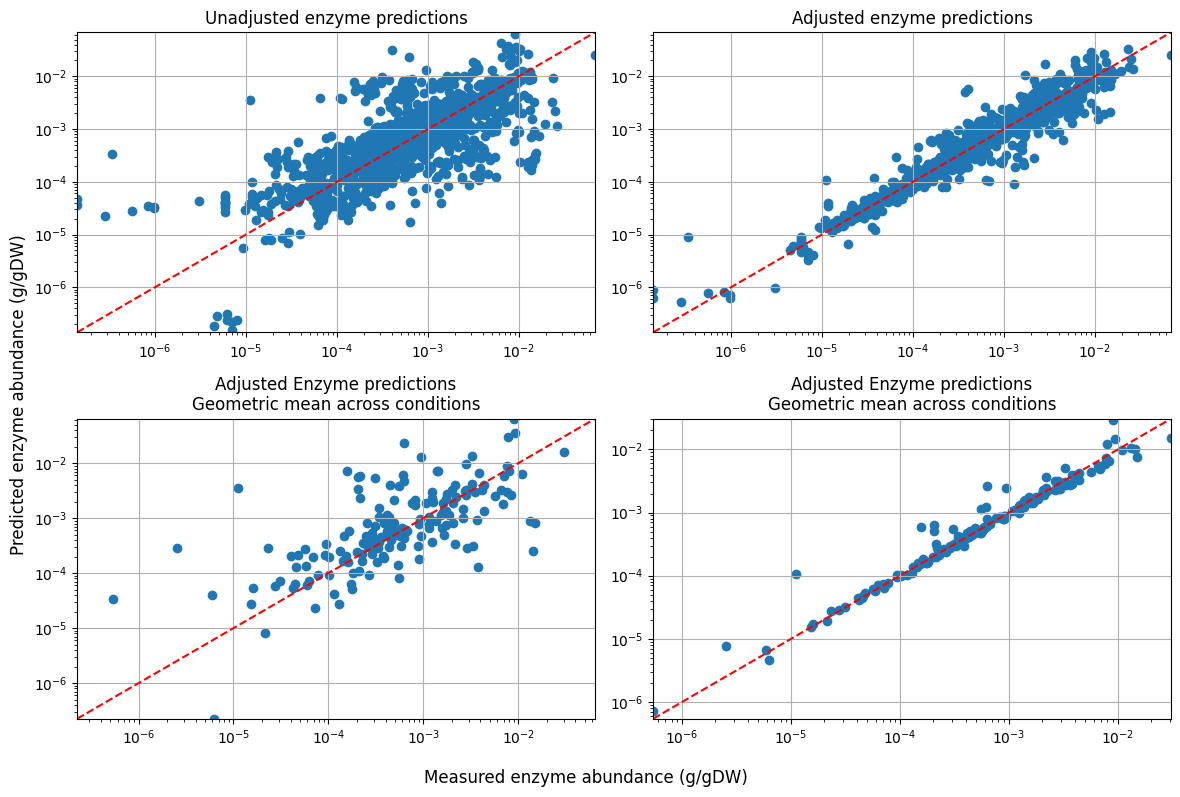

In [28]:
fig,ax=plt.subplots(2,2,figsize=(12,8))

#merge measured and predicted in one looong b_vectors

enzyme_allocations=results['enzyme_allocation']
kcats=results['kcats']


measured_all_cs=enzyme_allocations['measured'].values
predicted_all_cs=enzyme_allocations['adjusted_predicted'].values
predicted_all_cs_unadjusted=enzyme_allocations['unadjusted_predicted'].values

ax[0,0].scatter(measured_all_cs,predicted_all_cs_unadjusted)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(measured_all_cs[measured_all_cs>0]),np.min(predicted_all_cs_unadjusted[predicted_all_cs_unadjusted>0])),max(np.max(measured_all_cs[measured_all_cs>0]),np.max(predicted_all_cs_unadjusted[predicted_all_cs_unadjusted>0]))]
ax[0,0].set_xlim(shared_limits)
ax[0,0].set_ylim(shared_limits)
#Dra,0w diagonal line
ax[0,0].plot(shared_limits,shared_limits,'r--')
ax[0,0].grid()
ax[0,0].set_title('Unadjusted enzyme predictions')
#=========)


ax[0,1].scatter(measured_all_cs,predicted_all_cs)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(measured_all_cs[measured_all_cs>0]),np.min(predicted_all_cs[predicted_all_cs>0])),max(np.max(measured_all_cs[measured_all_cs>0]),np.max(predicted_all_cs[predicted_all_cs>0]))]
ax[0,1].set_xlim(shared_limits)
ax[0,1].set_ylim(shared_limits)
#Draw diagonal line

ax[0,1].plot(shared_limits,shared_limits,'r--')
ax[0,1].grid()
ax[0,1].set_title('Adjusted enzyme predictions')


#================================================================================================
GM_unadjusted=enzyme_allocations.query("unadjusted_predicted>0").groupby("enzyme").aggregate({'unadjusted_predicted':geometric_mean,'measured':geometric_mean})
GM_unadjusted['abs_log_error']=np.abs(np.log10(GM_unadjusted['measured'])-np.log10(GM_unadjusted['unadjusted_predicted']))
ax[1,0].scatter(GM_unadjusted['measured'],GM_unadjusted['unadjusted_predicted'])
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(GM_unadjusted['measured'][GM_unadjusted['measured']>0]),
                   np.min(GM_unadjusted['unadjusted_predicted'][GM_unadjusted['unadjusted_predicted']>0])),
               max(np.max(GM_unadjusted['measured'][GM_unadjusted['measured']>0]),
                   np.max(GM_unadjusted['unadjusted_predicted'][GM_unadjusted['unadjusted_predicted']>0]))]
ax[1,0].set_xlim(shared_limits)
ax[1,0].set_ylim(shared_limits)
#Draw diagonal line
ax[1,0].set_title("Adjusted Enzyme predictions\nGeometric mean across conditions")
ax[1,0].plot(shared_limits,shared_limits,'r--')
ax[1,0].grid()

#================================================================================================
GM=enzyme_allocations.query("adjusted_predicted>0").groupby("enzyme").aggregate({'adjusted_predicted':geometric_mean,'measured':geometric_mean})
GM['abs_log_error']=np.abs(np.log10(GM['measured'])-np.log10(GM['adjusted_predicted']))
ax[1,1].scatter(GM['measured'],GM['adjusted_predicted'])
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(GM['measured'][GM['measured']>0]),np.min(GM['adjusted_predicted'][GM['adjusted_predicted']>0])),max(np.max(GM['measured'][GM['measured']>0]),np.max(GM['adjusted_predicted'][GM['adjusted_predicted']>0]))]
ax[1,1].set_xlim(shared_limits)
ax[1,1].set_ylim(shared_limits)
#Draw diagonal line

ax[1,1].set_title("Adjusted Enzyme predictions\nGeometric mean across conditions")
ax[1,1].plot(shared_limits,shared_limits,'r--')
ax[1,1].grid()

fig.supxlabel("Measured enzyme abundance (g/gDW)")
fig.supylabel("Predicted enzyme abundance (g/gDW)")
plt.tight_layout()

## Test the effect of regularisation by scanning through different values of the ridge coefficient

In [16]:
results_ar=[]
rho_ar=10**np.linspace(3,-1,15)
carbon_sources=all_carbon_sources
#warm_start=None
warm_start=results['warm_start']
for ridge_coefficient in rho_ar:
    print(f"Running for lambda {ridge_coefficient}")
    print("==================================== \n\n")
    log10_kcats0=np.log10(kcats0)
    results=kcat_adjustment_pipeline(carbon_sources=carbon_sources,
                                    log10_kcats0=log10_kcats0,
                                    ridge_coefficient=ridge_coefficient,
                                    warm_start=warm_start)
    if not results['nlp_sol']['status']['success']:
        print(f"Failed to solve NLP for lambda {ridge_coefficient}")
        raise
    warm_start=results['warm_start']
    results_ar.append(results)

Running for lambda 1000.0


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2600 rows, 4032 columns and 16008 nonzeros
Model fingerprint: 0x8cdd85de
Coefficient statistics:
  Matrix range     [6e-04, 8e+01]
  Objective range  [4e-03, 4e+03]
  Bounds range     [1e+03, 1e+03]
  RHS range        [3e-01, 7e+00]
Presolve removed 2011 rows and 2936 columns
Presolve time: 0.01s
Presolved: 589 rows, 1096 columns, 4866 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5626703e+04   5.141554e+03   0.000000e+00      0s
Extra simplex iterations after uncrush: 92
     752    8.7546982e+02   0.000000e+00   0.000000e+00      0s

Solved in 752 iterations and 0.03 seconds (0.02 work units)
Optimal objective  8.754698192e+02
Solved LP with given log10_

### Verify that optiml flux distributions have not been changed by the adjustment procedure across all values of the regularisation coefficient

In [17]:
for cs in all_carbon_sources:
    for i,r_id in enumerate(reaction_ids):
        cur_std=np.std([res['final_lp_sol']['fluxes'][cs][i] for res in results_ar])
        if cur_std>1e-8:
            print(f"{r_id} in {cs} seems to change across lambda values: {[res['final_lp_sol']['fluxes'][cs][i] for res in results_ar]}")

# Based on the above results, we choose 1 as the choice of ridge regularisation coefficient. We repeat once more the optimsation for this value and export an updated EC model

In [18]:
carbon_sources=all_carbon_sources
log10_kcats0=np.log10(kcats0)
results=kcat_adjustment_pipeline(carbon_sources=carbon_sources,
                                log10_kcats0=log10_kcats0,
                                ridge_coefficient=1.)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2600 rows, 4032 columns and 16008 nonzeros
Model fingerprint: 0x8cdd85de
Coefficient statistics:
  Matrix range     [6e-04, 8e+01]
  Objective range  [4e-03, 4e+03]
  Bounds range     [1e+03, 1e+03]
  RHS range        [3e-01, 7e+00]
Presolve removed 2011 rows and 2936 columns
Presolve time: 0.00s
Presolved: 589 rows, 1096 columns, 4866 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5626703e+04   5.141554e+03   0.000000e+00      0s
Extra simplex iterations after uncrush: 92
     752    8.7546982e+02   0.000000e+00   0.000000e+00      0s

Solved in 752 iterations and 0.02 seconds (0.02 work units)
Optimal objective  8.754698192e+02
Solved LP with given log10_kcats and log10_sigmas for c

In [19]:
# Save results to file
results['enzyme_allocation'].to_csv('out/enzyme_predictions_adjusted_vs_unadjusted.csv')
results['scalings'].to_csv('out/fitted_sigmas.csv')
results['kcats'].to_csv('out/adjusted_kcats.csv')

with open("out/rho_sweep.pkl",'wb') as file:
    pickle.dump({'rho_ar':rho_ar,'results_ar':results_ar},file)

## Step 3: Convert into apparent turnover numbers
The above procedure produces (after conversion back to a linear scale) a set of adjusted turnover numbers, ${k}_{\rm cat}^*$ and scalings, ${\sigma}^*$. In order to facilitate the physical interpretation of the resulting parameter set,  we express the fitted scalings for the $j$th condition, $\sigma_j^*$ as the product of two terms: 
$$
    \sigma_j^* \equiv \bar{\sigma}^*~\hat{\sigma}_j^*
$$
Here, $\bar{\sigma}^*$ is the geometric mean of the scalings across conditions, which we interpret as typical enzyme saturation level, while $\hat{s}_j^*$ is a residual scaling factor fluctuating around $1$ which required to account for differences in total measured enzymes across conditions. Based on this reparametrisation of the scaling, we now define a set of adjusted \textit{apparent} turnover numbers, ${k}_{\rm cat}^{\rm app}$, which now incorporate saturation information, as:
$$
    {k}_{\rm cat}^{\rm app~*} \equiv \bar{\sigma}^*~{k}_{\rm cat}^*
$$

In [20]:
#Implement the above reparametrisation

scalings_geom_mean=geometric_mean(results['scalings'].values) #bar{sigma}^*
condition_specific_scalings={cs:x/scalings_geom_mean for cs,x in results['scalings'].items()} #\hat{sigma}_j^*

#Parse everything into a table
fitted_kcat_df={'reaction_id':[],'direction':[],'directional_reaction_id':[],'enzyme':[],'kapp_per_s':[]}
for i,row in results['kcats'].iterrows():
    directional_reaction_id=row['reaction_id']
    dir='fw' if '_fw' in directional_reaction_id else 'bw'
    reaction_id=directional_reaction_id.replace(f'_{dir}','')
    enzyme=row['enzyme']
    fitted_kcat_df['reaction_id'].append(reaction_id)
    fitted_kcat_df['direction'].append(dir)
    fitted_kcat_df['directional_reaction_id'].append(directional_reaction_id)
    fitted_kcat_df['enzyme'].append(enzyme)
    fitted_kcat_df['kapp_per_s'].append(row['adjusted_kcats']*scalings_geom_mean)
fitted_kcat_df=pd.DataFrame.from_dict(fitted_kcat_df)
fitted_kcat_df.to_csv('out/typical_kapps.csv')

pd.Series(condition_specific_scalings).to_csv('out/condition_specific_scalings.csv')

## Finally, make a version of EC-*i*CH360 wparametrised with the fitted turnover numbers (after reparametrisation, so that the model can be run without scaling)

In [21]:
scalings=pd.read_csv('out/condition_specific_scalings.csv',index_col=0)
kapp_table=pd.read_csv('out/typical_kapps.csv',index_col=0).set_index('directional_reaction_id').loc[[pair[0] for pair in reaction_enzyme_pairs]]

updated_ec_model=ec_model.copy()

updated_log10_kcats=np.log10(kapp_table['kapp_per_s'].values)
updated_flux_costs=flux_costs_from_kcats(log10_kcats=updated_log10_kcats,
                                        log10_sigma=0.,
                                        scaling=1)

enzyme_pool_pseudometabolite=updated_ec_model.metabolites.get_by_id('enzyme_pool')
for r_id,enzyme_id in reaction_enzyme_pairs:
    r_cost=updated_flux_costs[reaction_ids.index((r_id))]
    kcat_ix=reaction_enzyme_pairs.index((r_id,enzyme_id))
    updated_log10_kcat=updated_log10_kcats[kcat_ix]
    r=updated_ec_model.reactions.get_by_id(r_id)
    r.annotation['smoment_kcat_per_s']=10**(updated_log10_kcat)
    r.add_metabolites({enzyme_pool_pseudometabolite:-r_cost},combine=False)

#As a default bound for the enzyme pool, we will use the solution of the ECM LP problem with adjusted kcats (which should then yield the experimental growth rate)
sol_lp=solve_lp_problem(carbon_sources=['glc__D_e'],
                 log10_kcats=updated_log10_kcats,
                log10_sigmas={'glc__D_e':np.log10(scalings.loc['glc__D_e'][0])},
                verbose=True,scale_enzyme_predictions=False)
enzyme_pool_default_bound=sol_lp['unscaled_enzyme_predictions']['glc__D_e'].sum()
updated_ec_model.reactions.get_by_id('enzyme_pool_supply').upper_bound=enzyme_pool_default_bound
#Restore glucose uptake
updated_ec_model.reactions.get_by_id('EX_glc__D_e_bw').upper_bound=1000
#Save updated model to file
cobra.io.write_sbml_model(updated_ec_model,'../../Model/EC_iCH360/EC_iCH360_fitted_kapps.xml')
cobra.io.save_json_model(updated_ec_model,'../../Model/EC_iCH360/EC_iCH360_fitted_kapps.json')

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmpn1crgyf4.lp
Reading time = 0.02 seconds
: 305 rows, 1010 columns, 4816 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 325 rows, 504 columns and 2001 nonzeros
Model fingerprint: 0xb73a271e
Coefficient statistics:
  Matrix range     [6e-04, 8e+01]
  Objective range  [5e-03, 5e+04]
  Bounds range     [1e+03, 1e+03]
  RHS range        [6e-01, 7e+00]
Presolve removed 252 rows and 367 columns
Presolve time: 0.01s
Presolved: 73 rows, 137 columns, 597 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2799840e+03   6.726157e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 8
      88    2.8228398e+02   0.000000e+00   0.000000e+00      0s

Solved in 8